# Capstone 3: Corona Chest X-ray Image Processing

## 0. Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split # splitting train and validation data

# For visualizing images
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import random
#view data via a pandas profile
import pandas_profiling
from pandas_profiling.utils.cache import cache_file
from pandas_profiling import ProfileReport

from plotly.subplots import make_subplots
import plotly.graph_objects as go

# For augmenting data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# For modelling

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Dropout, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, Flatten, AveragePooling2D, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC, TruePositives, TrueNegatives, FalsePositives, FalseNegatives
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from sklearn.model_selection import StratifiedKFold

# For evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_curve

import os

## 1. Data Wrangling

- 1.1. Data Loading
- 1.2. Null Values
- 1.3. Load Data sets... in to train and test and correspond it with the directory of the respective images

### 1.1 Data Loading

In [2]:
metadata = pd.read_csv('../Data/Chest_xray_Corona_Metadata.csv')
metadata_summary = pd.read_csv('../Data/Chest_xray_Corona_dataset_Summary.csv')


train_directory = '../Data/Coronahack-Chest-XRay-Dataset/train'
test_directory = '../Data/Coronahack-Chest-XRay-Dataset/test'


In [3]:
metadata.tail()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
5905,5928,person1637_virus_2834.jpeg,Pnemonia,TEST,NaN,Virus
5906,5929,person1635_virus_2831.jpeg,Pnemonia,TEST,NaN,Virus
5907,5930,person1634_virus_2830.jpeg,Pnemonia,TEST,NaN,Virus
5908,5931,person1633_virus_2829.jpeg,Pnemonia,TEST,NaN,Virus
5909,5932,person1632_virus_2827.jpeg,Pnemonia,TEST,NaN,Virus


In [4]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5910 entries, 0 to 5909
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Unnamed: 0              5910 non-null   int64 
 1   X_ray_image_name        5910 non-null   object
 2   Label                   5910 non-null   object
 3   Dataset_type            5910 non-null   object
 4   Label_2_Virus_category  69 non-null     object
 5   Label_1_Virus_category  4334 non-null   object
dtypes: int64(1), object(5)
memory usage: 277.2+ KB


In [5]:
print("List of null values for each column: \n")
Missing_count = metadata.isna().sum().sort_values(ascending = False)[:25]
missing = pd.concat([Missing_count, (Missing_count/len(metadata))*100], axis=1, keys = ["count", "%"])
missing_type = pd.concat([metadata.isna().sum().sort_values(ascending = False), (metadata.isna().sum().sort_values(ascending = False)/len(metadata))*100,metadata.dtypes], axis=1, keys = ["count", "%", "types"])
print(missing_type.sort_values(by=["count"], ascending = False))


metadata.isnull().sum()

List of null values for each column: 

                        count          %   types
Label_2_Virus_category   5841  98.832487  object
Label_1_Virus_category   1576  26.666667  object
Unnamed: 0                  0   0.000000   int64
X_ray_image_name            0   0.000000  object
Label                       0   0.000000  object
Dataset_type                0   0.000000  object


Unnamed: 0                   0
X_ray_image_name             0
Label                        0
Dataset_type                 0
Label_2_Virus_category    5841
Label_1_Virus_category    1576
dtype: int64

In [6]:
#replace null data points to 'unknown'
metadata.fillna('unknown', inplace=True)
metadata.isnull().sum()

Unnamed: 0                0
X_ray_image_name          0
Label                     0
Dataset_type              0
Label_2_Virus_category    0
Label_1_Virus_category    0
dtype: int64

In [7]:
print((metadata['Label_1_Virus_category']).value_counts())
print((metadata['Label_2_Virus_category']).value_counts())

bacteria          2777
unknown           1576
Virus             1555
Stress-Smoking       2
Name: Label_1_Virus_category, dtype: int64
unknown          5841
COVID-19           58
Streptococcus       5
SARS                4
ARDS                2
Name: Label_2_Virus_category, dtype: int64


In [8]:
train_data = metadata[metadata['Dataset_type'] == 'TRAIN']
test_data = metadata[metadata['Dataset_type'] == 'TEST']

#### WE NEED TO ADD MORE IMAGES TO BOOST MODEL PERFORMANCE CUZ THERE ARE ONLY 58 PICTURES WITH COVID

In [9]:
print(f"Shape of train data: {train_data.shape}")
print(f"Shape of test data: {test_data.shape}")

Shape of train data: (5286, 6)
Shape of test data: (624, 6)


## 2. Exploratory Data Analysis

- 2.1 Create a pandas profile report to look at spread of values
- 2.2 Classify images into a class column to make the 4 types of images classifiable
- 2.3 Take a look at the images and plot histograms in each class and undestand visual difference


In [10]:
#profile = ProfileReport(metadata, title='Covid Data Report', explorative = True)
#profile
#profile.to_file("Covid-MetaData-Profile-Report.html")

In [11]:
#Lets saperate the images to classes of images: Healthy, Bacterial_Infection, 'COVID-19', 'Unknown'

#healthy people are classified by the label normal
train_data.loc[train_data['Label'].eq('Normal'), 'class'] = 'healthy'

#people who are not healthy and have label 1 as bacterial infection
train_data.loc[(train_data['class'].ne('healthy') & train_data['Label_1_Virus_category'].eq('bacteria')), 'class'] = 'bacteria';

# those labeled as covid-19 have corona virus
train_data.loc[(train_data['class'].ne('healthy') & train_data['class'].ne('bacteria') & train_data['Label_2_Virus_category'].eq('COVID-19')), 'class'] = 'COVID-19';

#and the missing labels are classified as unknowns
train_data.loc[(train_data['class'].ne('healthy') & train_data['class'].ne('bacteria') & train_data['class'].ne('COVID-19')), 'class'] = 'unknown';

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [12]:
class_dict = {'healthy' : 0,
               'bacteria' : 1,
               'COVID-19' : 2,
               'unknown' : 3}
train_data['target'] = train_data['class'].map(class_dict);

/var/folders/k2/pfnsxnrs1szbbnf62sz1wlzw0000gn/T/ipykernel_4122/110568831.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['target'] = train_data['class'].map(class_dict);


In [13]:
def plot_images(path,class_str,numdisplay):
    fig, ax = plt.subplots(numdisplay,2, figsize=(15,2.5*numdisplay))
    for row,file in enumerate(path):
        image = plt.imread(file)
#         print(image.shape)
        ax[row,0].imshow(image, cmap=plt.cm.bone)
        ax[row,1].hist(image.ravel(), 256, [0,256])
        ax[row,0].axis('off')
        if row == 0:
            ax[row,0].set_title('Images')
            ax[row,1].set_title('Histograms')
    fig.suptitle('Class='+class_str,size=16)
    plt.show() 

In [14]:
def display_class_images(img_path,dataset,classlabel,numdisplay):
    path = dataset[dataset['class']==classlabel]['X_ray_image_name'].values
    sample_path = path[:numdisplay]
    sample_path = list(map(lambda x: os.path.join(img_path,x), sample_path))
    plot_images(sample_path,classlabel,numdisplay)

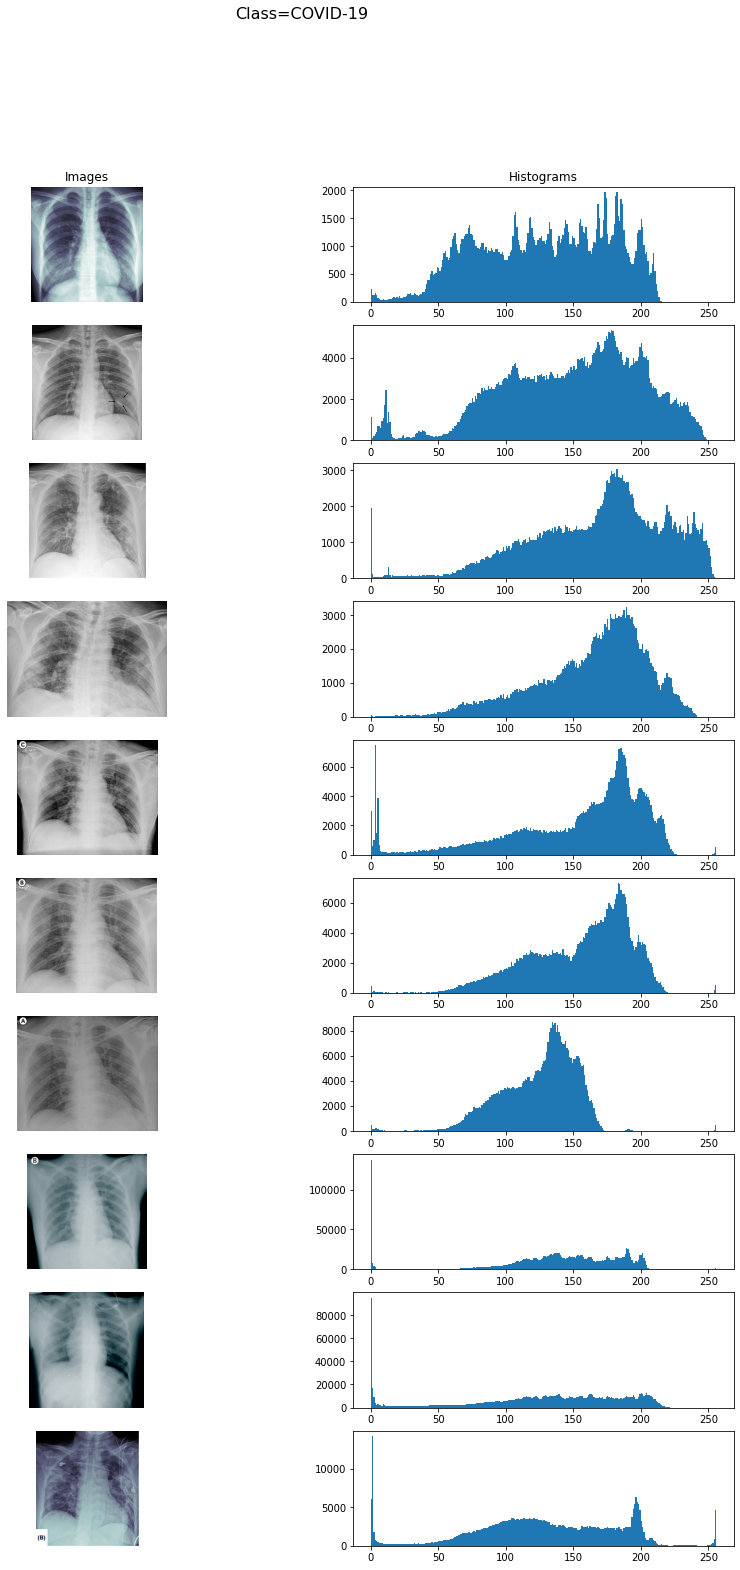

In [15]:
display_class_images(train_directory,train_data,"COVID-19",10)

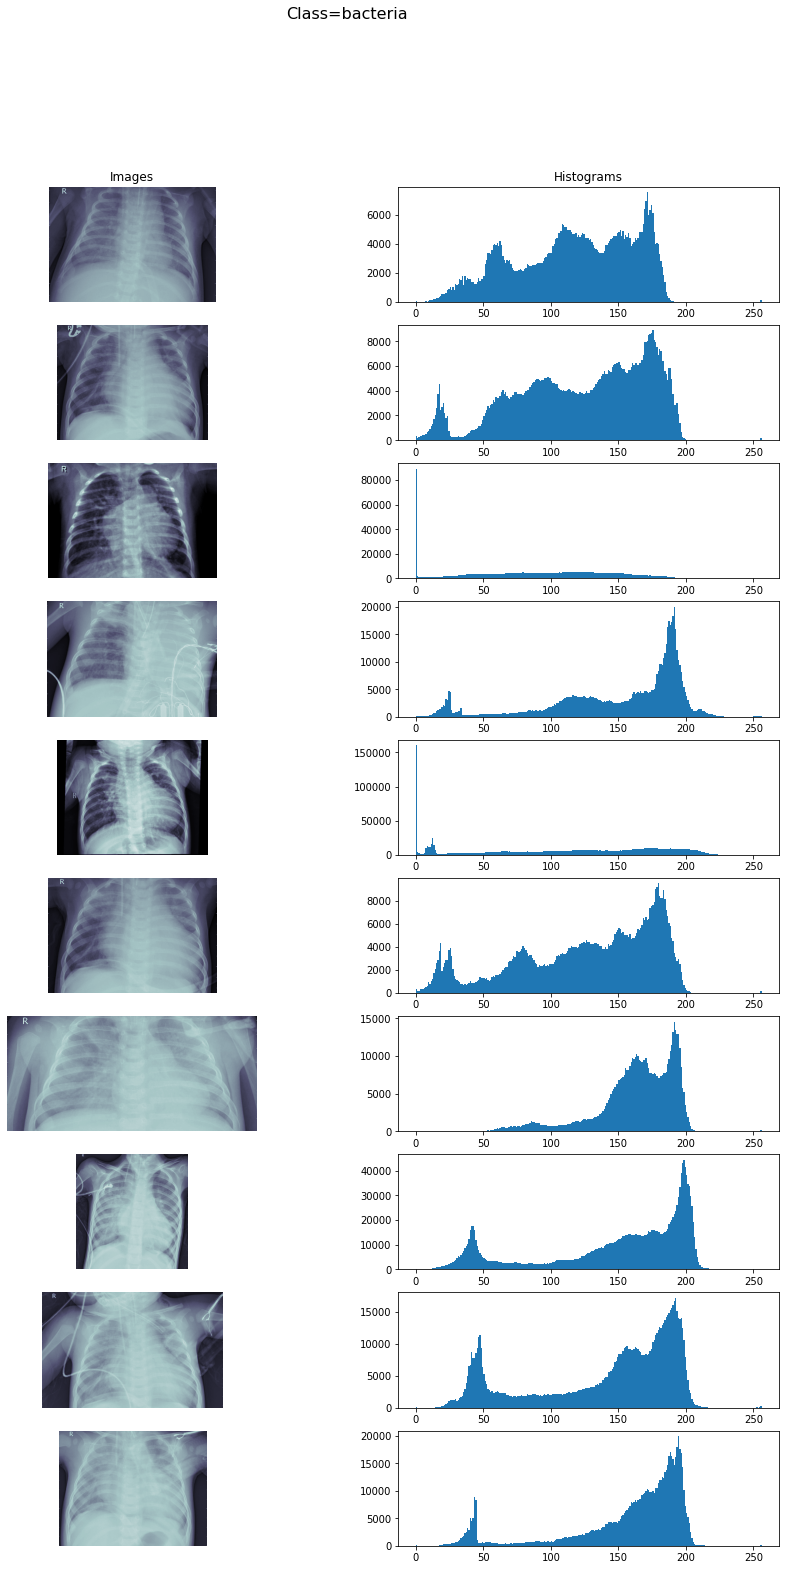

In [16]:
display_class_images(train_directory,train_data,"bacteria",10)

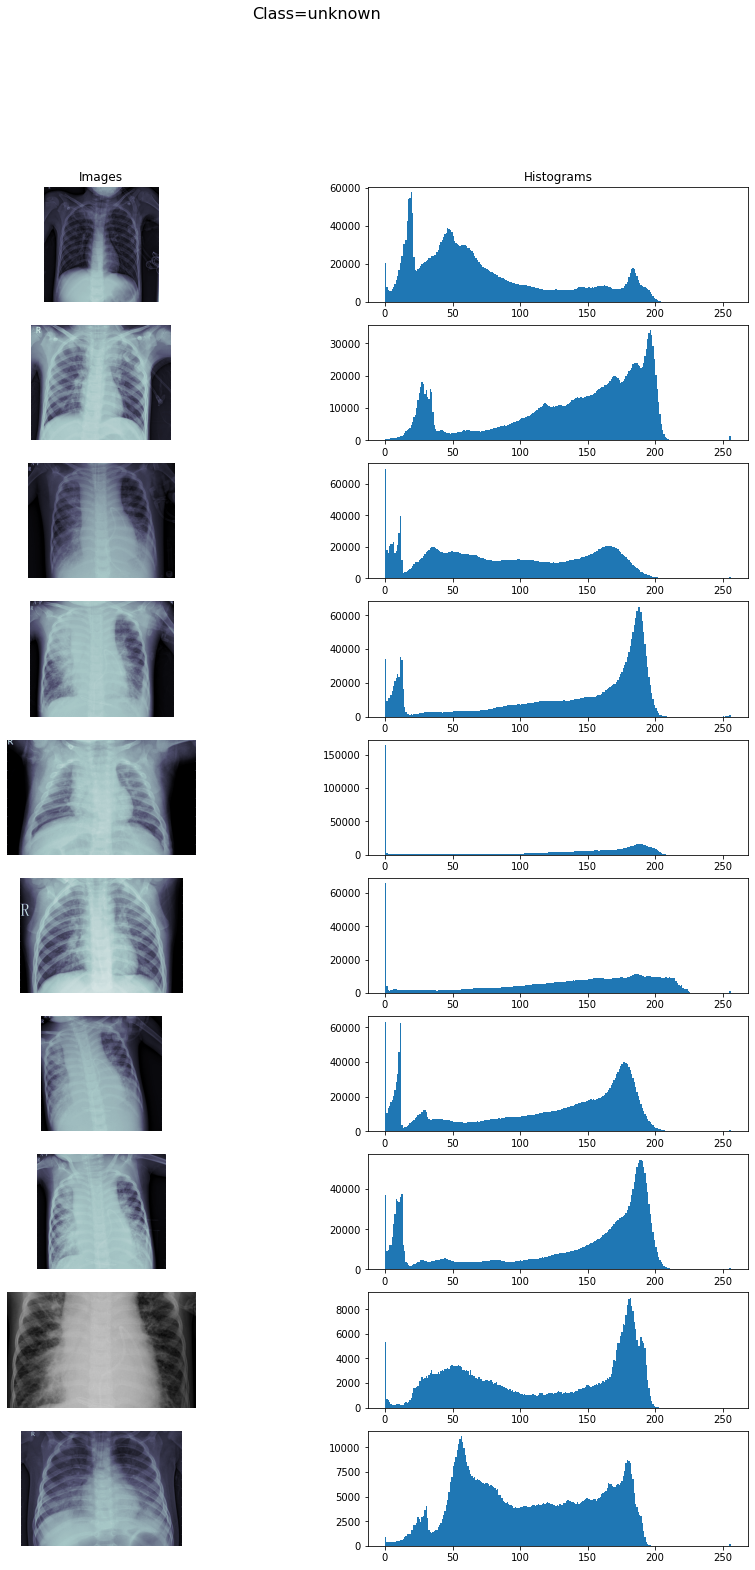

In [17]:
display_class_images(train_directory,train_data,"unknown",10)

## 3. Preprocessing Data

- 3.1 create data set matching meta data with images
- 3.2 Address the following 
    - scale thresholding
    - applying filters
    - transformations
    - segmentation
- 3.3 Create and check data batches

### 3.1 Create classified training set

instead of combining meta data with data set. I just classfied the images into saperate folders of:
Healthy, Bacterial_Infection, 'COVID-19', 'Unknown' as a saperate data set 

##### use below script to do so

In [18]:
# first, we need to address that we can't load data set using data loaders libraries 
# So let's saperate the data into respective folders

# import glob, shutil


# #saperate the images into folders of Healthy, Bacterial_Infection, 'COVID-19', 'Unknown'
# #path = train_data[train_data['class']=='COVID-19']['X_ray_image_name'].values


# old_directory = train_directory + '/' 

# new_directory = '../Data/Pre-processed-Coronahack-DataSet/'

# path = train_data[train_data['class']=='COVID-19']['X_ray_image_name'].values

# import glob, shutil
# image_classes = ['healthy', 'unknown', 'bacteria', 'COVID-19']
# #folder = open("/Users/foo/address.csv")
# for f in image_classes:
#     folder = f
#     new_images = train_data[train_data['class']==f]['X_ray_image_name'].values
#     for i in new_images:
#         shutil.copy((old_directory+ i), new_directory + f + '/' + i)


In [ ]:
# # first, we need to address that we can't load data set using data loaders libraries 
# #cuz the metadata associated with the images is in a saperate file.
# #Thankfully, Stackoverflow has provided some simple custom data set classes

# class CustomDataSet:
#     def __init__(self, image_dir, meta_data, transform):
#         self.image_dir = image_dir
#         self.meta_data = meta_data
#         self.transform = transform
#         self.total_imgs = os.listdir(image_dir)

#     def __len__(self):
#         return len(self.meta_data)

#     def __getitem__(self, index):
#         meta_data = self.meta_data.iloc[index] 
#         filename = meta_data['X_ray_image_name']
#         try:
#             file_index = self.total_imgs.index(filename)
#         except:
#             print("Data not found!")
#             return None        
#         img_loc = os.path.join(self.image_dir, self.total_imgs[file_index])
#         image = Image.open(img_loc).convert("RGB")
#         image = image.resize((128,128))
#         tensor_image = self.transform(image)
#         tensor_label = torch.tensor(meta_data['target'].item())
#         return tensor_image, tensor_label

# def my_collate(batch):
#     "Puts each data field into a tensor with outer dimension batch size"
#     batch = filter (lambda x:x is not None, batch)
#     return default_collate(list(batch))

### 3.2 Data Transformations

#### I didn't do any modifications to data for my first model. In future, I would recommend the following: 
 - combining larger datasets
 - restricting image sizes for faster training
 - scale thresholding and image transformations for consistency of params across images

### 3.3 Create and check data batches

In [20]:
train_data_classified = '../Data/Pre-processed-Coronahack-DataSet'
batchsize = 16

## 4. Model - Neural Network

In [21]:
rmdir ../Data/Pre-processed-Coronahack-DataSet/.ipynb_checkpoints

rmdir: ../Data/Pre-processed-Coronahack-DataSet/.ipynb_checkpoints: No such file or directory


In [22]:
datagen = ImageDataGenerator(validation_split=0.3,
                             rescale=1./255,
                             horizontal_flip=True,
                             vertical_flip=True,
                             zoom_range=0.2,
                             brightness_range=[1, 2])

train_generator = datagen.flow_from_directory(
    train_data_classified,
    target_size=(200, 200),
    batch_size=batchsize,
    class_mode="categorical",
    subset="training"
)

test_generator = datagen.flow_from_directory(
    train_data_classified,
    target_size=(200, 200),
    batch_size=batchsize,
    class_mode="categorical",
    subset="validation"
)

Found 3702 images belonging to 4 classes.
Found 1584 images belonging to 4 classes.


In [23]:
train_generator.class_indices

{'COVID-19': 0, 'bacteria': 1, 'healthy': 2, 'unknown': 3}

In [24]:
#specify initial CNN parameters

INPUT_SHAPE = (200, 200, 3)
KERNEL_SIZE = 4
POOL_SIZE = 4
STRIDES = 4
DROPOUT = 0.5

In [25]:
model = tf.keras.Sequential()
model.add(Conv2D(filters=64, kernel_size=KERNEL_SIZE, padding='same',
                 activation='relu', input_shape=INPUT_SHAPE))
model.add(MaxPooling2D(pool_size=POOL_SIZE, strides=STRIDES))
model.add(Dropout(DROPOUT))
model.add(Conv2D(filters=32, kernel_size=KERNEL_SIZE,
                 padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=POOL_SIZE, strides=STRIDES))
model.add(Dropout(DROPOUT))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(DROPOUT))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer="adam", loss="categorical_crossentropy",
              metrics=["accuracy"])

2022-01-03 20:53:55.700276: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 64)      3136      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 50, 50, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        32800     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 32)        0

Epoch 1/50
232/232 [==============================] - 273s 1s/step - loss: 1.1451 - accuracy: 0.4849
Epoch 2/50
232/232 [==============================] - 247s 1s/step - loss: 0.9623 - accuracy: 0.5746
Epoch 3/50
232/232 [==============================] - 261s 1s/step - loss: 0.8686 - accuracy: 0.6297
Epoch 4/50
232/232 [==============================] - 274s 1s/step - loss: 0.8088 - accuracy: 0.6548
Epoch 5/50
232/232 [==============================] - 422s 2s/step - loss: 0.7608 - accuracy: 0.6756
Epoch 6/50
232/232 [==============================] - 399s 2s/step - loss: 0.7562 - accuracy: 0.6788
Epoch 7/50
232/232 [==============================] - 346s 1s/step - loss: 0.7415 - accuracy: 0.6964
Epoch 8/50
232/232 [==============================] - 321s 1s/step - loss: 0.7275 - accuracy: 0.6964
Epoch 9/50
232/232 [==============================] - 301s 1s/step - loss: 0.7062 - accuracy: 0.7048
Epoch 10/50
232/232 [==============================] - 218s 939ms/step - loss: 0.6811 - acc

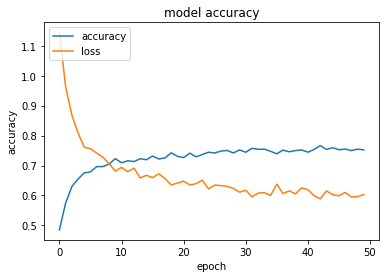

In [27]:
history = model.fit(train_generator, epochs=50)

metrics_train = model.evaluate(train_generator)
metrics_test = model.evaluate(test_generator)

print("Train Accuracy = %.4f - Train loss = %.4f" %
      (metrics_train[1], metrics_train[0]))
print("Test Accuracy = %.4f - Test loss = %.4f" %
      (metrics_test[1], metrics_test[0]))

plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

In [30]:
model.save('../Models/Sequential_Mark1')


INFO:tensorflow:Assets written to: ../Models/Sequential_Mark1/assets


In [31]:
#new_model = tf.keras.models.load_model('../Models/Sequential_Mark1')


## 5. Model Evaluation and Performance